In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False 

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
######## 读取数据 ########
sheet = pd.read_excel('data_input/美国10债Trend.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet.set_index('Date', inplace=True) 
sheet = sheet.reset_index().rename(columns={'index': 'Date'})

In [5]:
sheet = sheet.dropna()

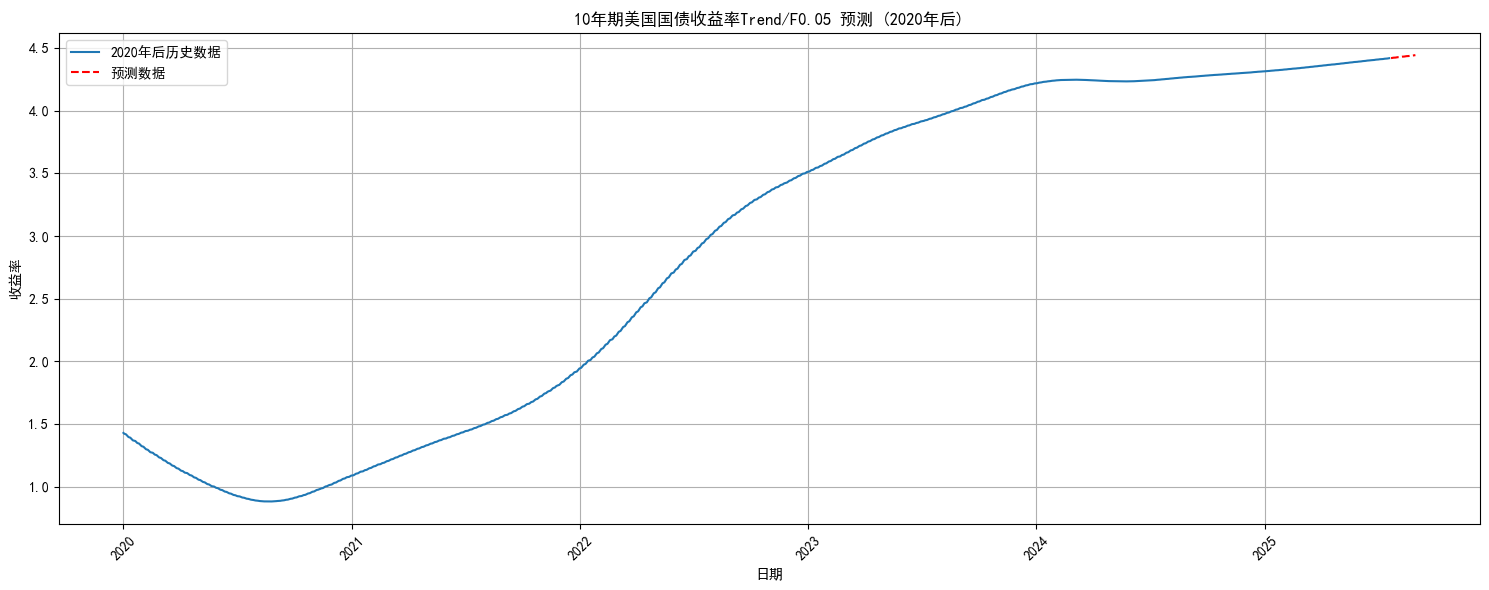

In [6]:
sheet = sheet.dropna()
# 获取最后一个日期
last_date = pd.to_datetime(sheet['Date'].iloc[-1])

# 生成未来30个工作日
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=45, freq='D')  # 生成45天以确保获得30个工作日
future_dates = future_dates[future_dates.dayofweek < 5][:30]  # 只保留工作日并取前30天

# 获取最后30个历史值用于线性回归
last_values = sheet['10年期美国国债收益率Trend/F0.05'].tail(30).values
x = np.arange(len(last_values))
y = last_values

# 进行线性回归
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# 预测未来30个值
future_x = np.arange(len(last_values), len(last_values) + 30)
future_values = p(future_x)

# 创建预测数据框
future_df = pd.DataFrame({
    'Date': future_dates,
    '10年期美国国债收益率Trend/F0.05': future_values
})

# 合并历史数据和预测数据
sheet_with_predictions = pd.concat([sheet, future_df], ignore_index=True)


# 筛选2020年之后的数据
sheet_2020 = sheet[sheet['Date'] >= '2020-01-01']

# 绘制结果
plt.figure(figsize=(15, 6))
plt.plot(sheet_2020['Date'], sheet_2020['10年期美国国债收益率Trend/F0.05'], label='2020年后历史数据')
plt.plot(future_df['Date'], future_df['10年期美国国债收益率Trend/F0.05'], 'r--', label='预测数据')
plt.title('10年期美国国债收益率Trend/F0.05 预测 (2020年后)')
plt.xlabel('日期')
plt.ylabel('收益率')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


---

In [7]:
########################   读取数据  #########################################
sheet_non_trend = pd.read_excel('eta/10年期美国国债收益率Non-Trend-F0.05_合并数据.xlsx', sheet_name='Sheet1')

In [8]:
# 将Date列转换为datetime64[ns]格式
sheet_non_trend['Date'] = pd.to_datetime(sheet_non_trend['Date'])

merged_df = pd.merge(
    sheet_non_trend[['Date', '预测值']], 
    future_df[['Date', '10年期美国国债收益率Trend/F0.05']], 
    on='Date',
    how='outer'
)
# 删除包含空值的行
merged_df = merged_df.dropna()

# 计算最终的
merged_df['10年期美国国债收益率'] = merged_df['预测值'] + merged_df['10年期美国国债收益率Trend/F0.05']


merged_df.head()

,Date,预测值,10年期美国国债收益率Trend/F0.05,10年期美国国债收益率
638,2025-07-21,-0.108105,4.420286,4.312182
639,2025-07-22,-0.110131,4.421112,4.310981
640,2025-07-23,-0.120393,4.421938,4.301545
641,2025-07-24,-0.122689,4.422764,4.300076
642,2025-07-25,-0.148993,4.423590,4.274597


In [9]:
sheet_2020.tail(1)

,Date,10年期美国国债收益率Trend/F0.05,10年期美国国债收益率
8435,2025-07-18,4.419478,4.44


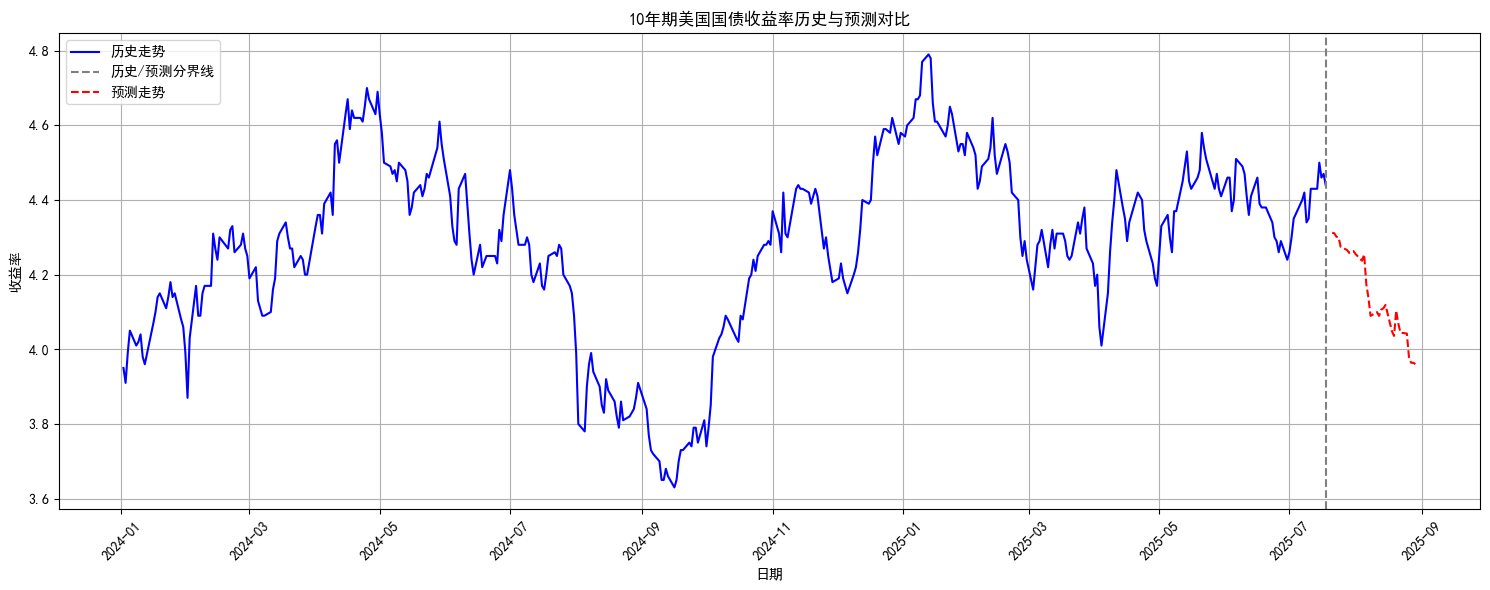

In [10]:
# 绘制最终走势图
plt.figure(figsize=(15, 6))

# 筛选2020年之后的数据
sheet_2020 = sheet[sheet['Date'] >= '2024-01-01']

# 绘制历史数据
plt.plot(sheet_2020['Date'], sheet_2020['10年期美国国债收益率'], label='历史走势', color='blue')

# 添加垂直分隔线,标记历史数据和预测数据的分界点
last_historical_date = sheet_2020['Date'].iloc[-1]
plt.axvline(x=last_historical_date, color='gray', linestyle='--', label='历史/预测分界线')

# 绘制预测数据
plt.plot(merged_df['Date'], merged_df['10年期美国国债收益率'], label='预测走势', color='red', linestyle='--')

plt.title('10年期美国国债收益率历史与预测对比')
plt.xlabel('日期')
plt.ylabel('收益率')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---

In [11]:
sheet_data_2023_shizhi = sheet[sheet['Date'].dt.year >= 2023][['Date', '10年期美国国债收益率']]
sheet_data_2023_shizhi.columns = ['Date', '实际值']
future_df_shizhi = merged_df[['Date', '10年期美国国债收益率']]
merged_df_shizhi = pd.merge(sheet_data_2023_shizhi, future_df_shizhi, on='Date', how='outer')
merged_df_shizhi = merged_df_shizhi.sort_values('Date', ascending=False)
merged_df_shizhi['Date'] = merged_df_shizhi['Date'].dt.strftime('%Y/%m/%d')
merged_df_shizhi.to_excel('eta/10年期美国国债收益率_合并数据.xlsx', index=False,float_format='%.5f')
merged_df_shizhi 

,Date,实际值,10年期美国国债收益率
665,2025/08/29,NaN,3.960250
664,2025/08/28,NaN,3.963864
663,2025/08/27,NaN,3.963971
662,2025/08/26,NaN,3.977957
661,2025/08/25,NaN,4.042261
...,...,...,...
4,2023/01/09,3.53,NaN
3,2023/01/06,3.55,NaN
2,2023/01/05,3.71,NaN
1,2023/01/04,3.69,NaN


In [12]:
# 将日期列转换为datetime格式
merged_df_shizhi['Date'] = pd.to_datetime(merged_df_shizhi['Date'])

# 按月份重采样并取每月最后一个交易日的数据
monthly_df_shizhi = merged_df_shizhi.set_index('Date').resample('ME').last()
monthly_df_shizhi = monthly_df_shizhi.sort_values('Date', ascending=False)
# 重置索引并格式化日期
monthly_df_shizhi = monthly_df_shizhi.reset_index()
monthly_df_shizhi['Date'] = monthly_df_shizhi['Date'].dt.strftime('%Y/%m/%d')

# 保存月度数据到Excel
monthly_df_shizhi.to_excel('eta/10年期美国国债收益率_月度数据.xlsx', index=False, float_format='%.2f')

monthly_df_shizhi.head()


,Date,实际值,10年期美国国债收益率
0,2025/08/31,NaN,3.960250
1,2025/07/31,4.44,4.263148
2,2025/06/30,4.24,NaN
3,2025/05/31,4.41,NaN
4,2025/04/30,4.17,NaN


---

In [13]:
sheet_data_2023 = sheet[sheet['Date'].dt.year >= 2023][['Date', '10年期美国国债收益率Trend/F0.05']]
sheet_data_2023.columns = ['Date', '实际值']
merged_df_trend = pd.merge(sheet_data_2023, future_df, on='Date', how='outer')
merged_df_trend = merged_df_trend.sort_values('Date', ascending=False)
merged_df_trend['Date'] = merged_df_trend['Date'].dt.strftime('%Y/%m/%d')
merged_df_trend.to_excel('eta/10年期美国国债收益率Trend—F0.05_合并数据.xlsx', index=False,float_format='%.5f')
merged_df_trend

,Date,实际值,10年期美国国债收益率Trend/F0.05
665,2025/08/29,NaN,4.444240
664,2025/08/28,NaN,4.443414
663,2025/08/27,NaN,4.442588
662,2025/08/26,NaN,4.441762
661,2025/08/25,NaN,4.440936
...,...,...,...
4,2023/01/09,3.529836,NaN
3,2023/01/06,3.526224,NaN
2,2023/01/05,3.522612,NaN
1,2023/01/04,3.519000,NaN


In [14]:
# 将日期列转换为datetime格式
merged_df_trend['Date'] = pd.to_datetime(merged_df_trend['Date'])

# 按月份重采样并取每月最后一个交易日的数据
monthly_df_trend = merged_df_trend.set_index('Date').resample('ME').last()
monthly_df_trend = monthly_df_trend.sort_values('Date', ascending=False)
# 重置索引并格式化日期
monthly_df_trend = monthly_df_trend.reset_index()
monthly_df_trend['Date'] = monthly_df_trend['Date'].dt.strftime('%Y/%m/%d')

# 保存月度数据到Excel
monthly_df_trend.to_excel('eta/10年期美国国债收益率Trend—F0.05_月度数据.xlsx', index=False, float_format='%.2f')

monthly_df_trend.head()

,Date,实际值,10年期美国国债收益率Trend/F0.05
0,2025/08/31,NaN,4.444240
1,2025/07/31,4.419478,4.426894
2,2025/06/30,4.408713,NaN
3,2025/05/31,4.392251,NaN
4,2025/04/30,4.375220,NaN


---

In [15]:
''''''
future_predictions = merged_df_shizhi[['Date', '10年期美国国债收益率']]
future_predictions = future_predictions.dropna()
future_predictions['Date'] = pd.to_datetime(future_predictions['Date'])
future_predictions = future_predictions.sort_values('Date')
future_predictions.to_csv('data_output/10年期美国国债收益率_未来日度预测.csv', index=False)
future_predictions.head()

,Date,10年期美国国债收益率
636,2025-07-21,4.312182
637,2025-07-22,4.310981
638,2025-07-23,4.301545
639,2025-07-24,4.300076
640,2025-07-25,4.274597


---

In [16]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "10年期美国国债收益率Trend/F0.05"

# 调用函数更新数据
success = update_excel_data(merged_df_trend, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [17]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "10年期美国国债收益率"

# 调用函数更新数据
success = update_excel_data(merged_df_shizhi, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [18]:
from Lcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "详情页"
identifier = "10年期美国国债收益率Trend/F0.05"

# 调用函数更新数据
success = update_excel_data(monthly_df_trend, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

已完成：插入/更新数据，并重新计算“方向/偏差率” (protected_date = 2025/07/31)
数据已成功更新到Excel文件


In [19]:
from Lcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "详情页"
identifier = "10年期美国国债收益率"

# 调用函数更新数据
success = update_excel_data(monthly_df_shizhi, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

已完成：插入/更新数据，并重新计算“方向/偏差率” (protected_date = 2025/07/31)
数据已成功更新到Excel文件
